<a href="https://colab.research.google.com/github/ilyes495/DNNs/blob/master/resnet50_basic_datablocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#read/write image data
!pip install imageio
#deep learning library
!pip install -U torch torchvision fastai
#access kaggle datasets from colab
!pip install kaggle
#model loading
!pip install ipywidgets



    100% |████████████████████████████████| 3.3MB 6.4MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
    100% |████████████████████████████████| 519.5MB 22kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59c72000 @  0x7faa0c5842a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 22.3MB/s 
    100% |████████████████████████████████| 122kB 32.0MB/s 
    100% |████████████████████████████████| 2.0MB 4.1MB/s 
    100% |████████████████████████████████| 163kB 28.7MB/s 
    100% |████████████████████████████████| 112kB 8.2MB/s 
    100% |███████████████████████████████

In [15]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ilyes23","key":"0361443474fe8ff45b79dd7445edc3ce"}'}

In [0]:
! rm *.json

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [1]:
!kaggle competitions download -c human-protein-atlas-image-classification

/bin/bash: kaggle: command not found


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from resnet import Resnet4Channel

In [0]:
bs = 64

In [0]:
path = Path('../')

In [0]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [0]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png' )
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [0]:
?? ImageItemList

In [0]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [0]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [0]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [0]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [0]:
test_fnames[:5]

[PosixPath('../test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('../test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('../test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('../test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('../test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [0]:
src.add_test(test_fnames, label='0');

In [0]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [0]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [0]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [0]:
?? get_transforms

In [0]:
data = (src.transform((trn_tfms, _), size=224, padding_mode= 'zeros', num_workers=0)
        .databunch().normalize(protein_stats))

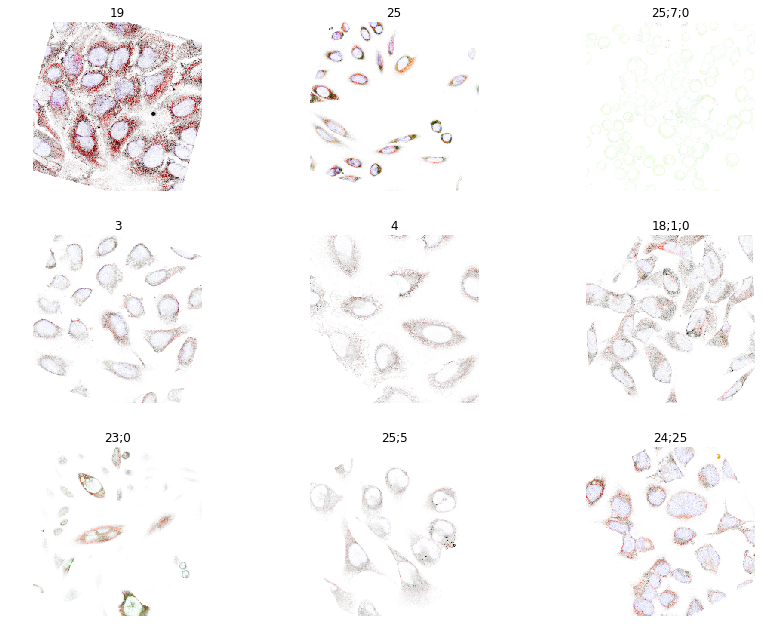

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [0]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])

In [0]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [0]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [0]:
?? create_cnn

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: DataLoader worker (pid 14937) is killed by signal: Unknown signal: 0. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

In [0]:
learn.recorder.plot()

In [0]:
lr = 3e-2

In [0]:
learn.fit_one_cycle(5, slice(lr))

Total time: 10:40
epoch  train_loss  valid_loss  fbeta   
1      0.135880    0.143851    0.496961  (02:09)
2      0.137360    0.139784    0.518900  (02:07)
3      0.125225    0.126279    0.582821  (02:07)
4      0.115448    0.126466    0.626896  (02:07)
5      0.105616    0.105299    0.644369  (02:08)



In [0]:
learn.save('stage-1-rn50-datablocks')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


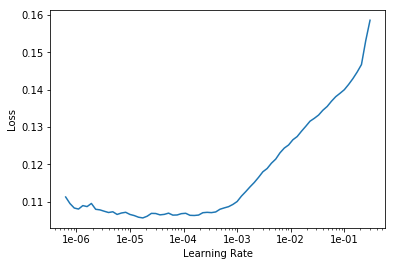

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15, slice(3e-5, lr/5))

Total time: 39:10
epoch  train_loss  valid_loss  fbeta   
1      0.109667    0.155611    0.626423  (02:36)
2      0.110943    0.114875    0.623779  (02:36)
3      0.109368    0.150954    0.612238  (02:36)
4      0.108172    0.141205    0.587201  (02:36)
5      0.108150    0.130050    0.637721  (02:36)
6      0.102617    0.108451    0.619096  (02:36)
7      0.102491    0.187115    0.635789  (02:36)
8      0.100008    0.098371    0.661671  (02:36)
9      0.096139    0.099643    0.683945  (02:36)
10     0.093640    0.094433    0.678350  (02:36)
11     0.089169    0.090767    0.688339  (02:36)
12     0.087881    0.088234    0.697956  (02:36)
13     0.085696    0.091604    0.696905  (02:36)
14     0.083266    0.087665    0.695674  (02:36)
15     0.083326    0.086742    0.699768  (02:36)



In [0]:
learn.save('stage-2-rn50')

In [0]:
preds,_ = learn.get_preds(DatasetType.Test)

/home/william/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)